<a href="https://colab.research.google.com/github/ygmurkara/DI501/blob/main/Lab_4_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DI 501: Clustering
## Banknote Authentication

In this portion of the lab different clustering algorithms will be implemented and optimized. Different ways of showing multidimensional features in a 2d grid is also shown.

This dataset is made up of fourier features of images of banknotes and their authenticity. (0 = forged, 1 = legitimate). The dataset was manually corrupted such that 80% of observations lose their labels.

We will first analyze the features only with clustering algorithms. Then we will use a self organizing map to learn from the few labeled examples we have, along with the clustering information it finds to label the test set. (Test set is purely chosen from the part with labels.)

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import preprocessing

from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, roc_auc_score, fbeta_score

from sklearn.datasets import make_blobs

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn_som.som import SOM
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [ ]:
data2 = pd.read_table("data_banknote_authentication.txt",sep=',',header=None)
data2.columns = ['x0','x1','x2','x3','y']

he = data2.sample(frac=1,random_state = 1).reset_index(drop=True)

X, y = he.iloc[:,:-1], he.y

labeld = 0.2
st = int(1372*labeld)

y[st:] = -1

X_train = X[st//2:]
y_train = y[st//2:]

X_test = X[:st//2]
y_test = y[:st//2]


/var/folders/5p/rbnmtvhx5437fb_9sp9b1ln80000gn/T/ipykernel_42568/3218676647.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[st:] = -1


## K-Means Clustering

We will try different k for K-Means clustering by first observing the relative distribution of clusters, as well as the within cluster SSE's. Notice how we preprocess the data before feeding into the model.

Here we first plot the most prominent two components from our four features using the PCA algorithm. Then we color each point by the class indicator given from KMeans.

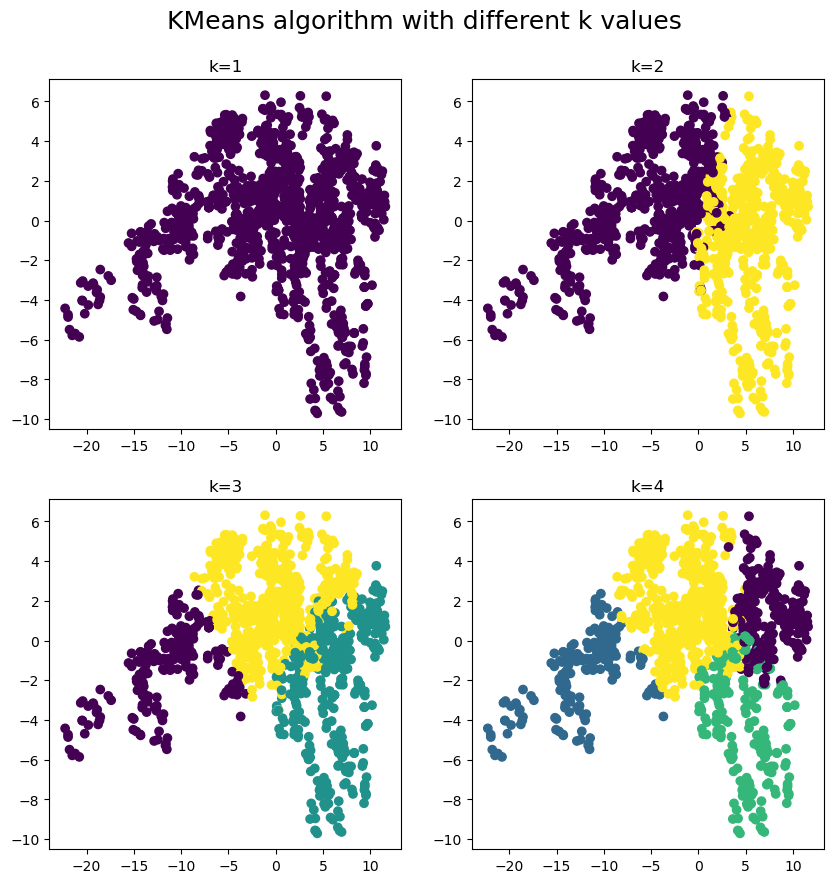

In [ ]:
fig, axes = plt.subplots(2,2, figsize=[10,10])

pcax = PCA(n_components=2)
tsvd = TruncatedSVD(n_components=2)
tsne = TSNE(n_components=2)

decomp_x = pcax.fit_transform(X_train)
# decomp_x = tsvd.fit_transform(X_train)
# decomp_x = tsne.fit_transform(X_train)

sse = []
scaler = preprocessing.StandardScaler()
for i in range(4):
    km = KMeans(i+1, random_state=0, n_init=10)
    pipe = make_pipeline(scaler,km)
    pred = pipe.fit_predict(X_train)
    sse.append(km.inertia_)

    plt.suptitle('KMeans algorithm with different k values',fontsize=18,y=0.95)
    axes.flatten()[i].set_title(f'k={i+1}')
    axes.flatten()[i].scatter(decomp_x[:,0],decomp_x[:,1],c=pred)

Lets also look at the within cluster SSE and determine the number of clusters with the elbow method.

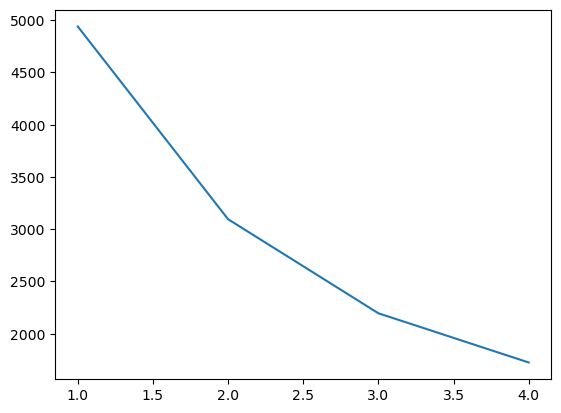

In [ ]:
plt.plot(range(1,5),sse)

Looks like either number of classes 2 or 3 is sufficient for this task. Since we know the answer is 2, lets go along with that.

## Agglomerative Clustering

Next is a simple demo of different agglomerative clustering algorithms with different distance metrics.

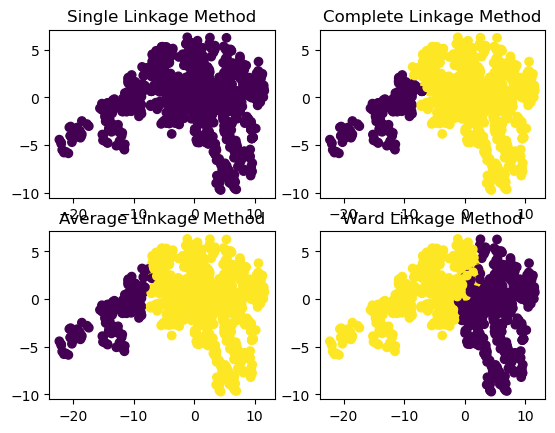

In [ ]:
for i,l in enumerate(['single','complete','average','ward']):
  link = linkage(X_train, method=l)
  y___ = fcluster(link, t=2, criterion='maxclust')
  plt.subplot(2,2,i+1)
  plt.title(f'{l.capitalize()} Linkage Method')
  plt.scatter(decomp_x[:,0],decomp_x[:,1],c=y___)

Given cluster size of 2, ward linkage method gives the most suitable division.

## Self-Organizing Maps

Self organizing maps generate a custom 2d grid to map observations onto, while also assigning them to apropriate clusters. These are akin to neural networks in that they need to be trained with learning rates, and they have hyperparameters to adjust.

In [ ]:
somscale = preprocessing.StandardScaler()
scaled_X = somscale.fit_transform(X_train)

so = SOM(m=10,n=10,dim=4,lr=0.5,sigma=4,max_iter=75000,random_state=1)

so.fit(scaled_X,epochs=75000)

We will use it the classifier implementation, since we have some labeled examples but most observations are missing labels. (A semi-supervised classification task.) We will also search over some parameter options and use randomized search.

In [ ]:
import susi
param_grid = {
    "n_rows": [5, 10, 20],
    "n_columns": [5, 20, 40],
    "learning_rate_start": [0.5, 0.7, 0.9],
    "learning_rate_end": [0.1, 0.05, 0.005],
}
som = susi.SOMClassifier(random_state=1,missing_label_placeholder=-1)

clf = RandomizedSearchCV(som, param_grid, random_state=1,verbose=3)
clf.fit(scaled_X,y_train)
print(clf.best_params_)
print(clf.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate_end=0.005, learning_rate_start=0.7, n_columns=5, n_rows=5;, score=0.073 total time=   0.1s
[CV 2/5] END learning_rate_end=0.005, learning_rate_start=0.7, n_columns=5, n_rows=5;, score=0.081 total time=   0.1s
[CV 3/5] END learning_rate_end=0.005, learning_rate_start=0.7, n_columns=5, n_rows=5;, score=0.085 total time=   0.1s
[CV 4/5] END learning_rate_end=0.005, learning_rate_start=0.7, n_columns=5, n_rows=5;, score=0.061 total time=   0.1s
[CV 5/5] END learning_rate_end=0.005, learning_rate_start=0.7, n_columns=5, n_rows=5;, score=0.045 total time=   0.1s
[CV 1/5] END learning_rate_end=0.05, learning_rate_start=0.5, n_columns=5, n_rows=5;, score=0.057 total time=   0.1s
[CV 2/5] END learning_rate_end=0.05, learning_rate_start=0.5, n_columns=5, n_rows=5;, score=0.077 total time=   0.1s
[CV 3/5] END learning_rate_end=0.05, learning_rate_start=0.5, n_columns=5, n_rows=5;, score=0.057 total time=   0.1

The accuracy score is so low because most labels are missing. 0.08 is in terms of 20% of the labeled data, so it can be scaled up.

In [ ]:
somm = susi.SOMClassifier(20,40,learning_rate_start=0.9,learning_rate_end=0.05,random_state=1,missing_label_placeholder=-1)

In [ ]:
somm.fit(somscale.transform(X_train),y_train)

SOMClassifier(learning_rate_start=0.9, missing_label_placeholder=-1,
              n_columns=40, n_rows=20, random_state=1)

Here we can see despite not having many labeled examples, the clustering side helped the model distinguish the two classes fairly decently.

In [ ]:
clusters = somm.get_clusters(somscale.transform(X_test))
test_pred = somm.predict(somscale.transform(X_test))

print(confusion_matrix(y_test,test_pred))
print(sum(test_pred == y_test)/len(y_test))



[[61 14]
 [12 50]]
0.8102189781021898


In [ ]:
df_clusters = pd.DataFrame({'cluster': clusters, 'true_label': y_test.tolist()})
print(df_clusters.head())

    cluster  true_label
0  [19, 16]           1
1   [4, 23]           0
2  [19, 39]           1
3   [19, 1]           1
4   [0, 30]           0


The SOM grid can also be plotted with many functions. More information can be found here:

[Example notebook on susi.SOMClustering and other plotting functions](https://github.com/felixriese/susi/blob/main/examples/SOMClustering.ipynb)

[Example notebook on how to import and use SuSi for classification](https://github.com/felixriese/susi/blob/main/examples/SOMClassifier_semisupervised.ipynb)

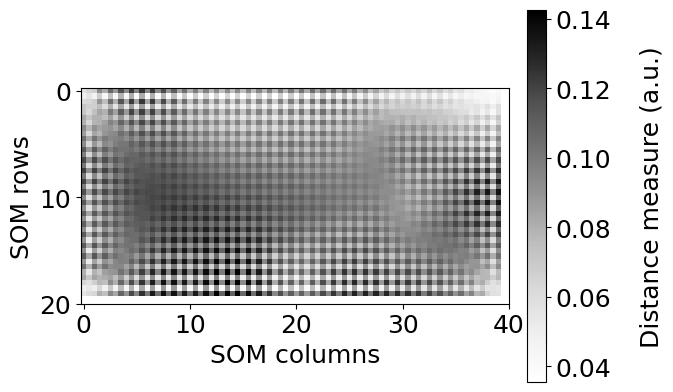

In [ ]:
from susi.SOMPlots import plot_nbh_dist_weight_matrix, plot_umatrix
u_matrix = somm.get_u_matrix()
plot_umatrix(u_matrix, 20, 40)
plt.show()